# Imports

In [1]:
%load_ext autoreload
%autoreload 2
# from QC_code import *
import xarray
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize 

import numpy as np
from matplotlib import cm
import matplotlib.patches as mpatches
import proplot as pplt
import matplotlib as mpl
import matplotlib.colors as mcolors
from itertools import cycle


# load data

In [2]:
# load simulated data
label_all = np.load('data/G_label.npy')
G_LL_all  = np.load('data/GLL.npy')
G_RR_all  = np.load('data/GRR.npy')

label_minus = np.copy(label_all)[:,0]
label_plus = np.copy(label_all)[:,0]

for i in range (len(label_all)):
    label_minus[i] = label_all[i,0] - label_all[i,1] 
    label_plus[i] = label_all[i,0] + label_all[i,1]
    
label_minus = label_minus.reshape(-1,1)

label_plus = label_plus.reshape(-1,1)

#label_ratio = abs( label_new / label_plus )
label_ratio = label_minus / label_plus

label_ratio_abs = abs(label_minus) / abs(label_plus)


In [3]:
# post processing GLL*GRR
G_LL_RR = np.zeros((len(G_LL_all),56,56))

for i in range(len(G_LL_RR)):
    G_LL_RR[i,:,:] = np.multiply(G_LL_all[i,:,:], G_RR_all[i,:,:])
    
G_LL_all = G_LL_all / np.amax(G_LL_all)
G_RR_all = G_RR_all / np.amax(G_LL_all)

# training/test data
lenght_test = 300
lenght = len(G_LL_all) - lenght_test

G_LL_28 = np.zeros((lenght,28,28,1))
G_RR_28 = np.zeros((lenght,28,28,1))

G_LL_RR = G_LL_RR / np.amax(G_LL_RR) # normalize G_LL*G_RR
G_LL_RR_28 = np.zeros((lenght,28,28,1))

# reshape to 28x28 pixels (experimental resolution)
for l in range(lenght):
    G_LL_28[l,:,:,0] = resize(G_LL_all[l,:,:],(28,28))  
    G_RR_28[l,:,:,0] = resize(G_RR_all[l,:,:],(28,28)) 
    G_LL_RR_28[l,:,:,0] = resize(G_LL_RR[l,:,:],(28,28)) 
        
# testing data  
G_LL_28_test = np.zeros((lenght_test,28,28,1))
G_RR_28_test = np.zeros((lenght_test,28,28,1))
G_LL_RR_28_test = np.zeros((lenght_test,28,28,1))

# reshape to 28x28 pixels (experimental resolution)
for l in range(lenght_test):
    G_LL_28_test[l,:,:,0] = resize(G_LL_all[lenght+l,:,:],(28,28)) 
    G_RR_28_test[l,:,:,0] = resize(G_RR_all[lenght+l,:,:],(28,28))    
    G_LL_RR_28_test[l,:,:,0] = resize(G_LL_RR[lenght+l,:,:],(28,28))    
   

# CNN model

In [4]:
# CNN model (same as in the automated tuning library)

# set random seed
tf.random.set_seed(42)

input_1 = Input(shape=(28, 28, 1))
input_2 = Input(shape=(28, 28, 1))

# Define convolutional layers for image 1
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_1)
pool1_1 = MaxPooling2D((2, 2))(conv1_1)
conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1_1)
pool2_1 = MaxPooling2D((2, 2))(conv2_1)
flat1 = Flatten()(pool2_1)

# Define convolutional layers for image 2
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_2)
pool1_2 = MaxPooling2D((2, 2))(conv1_2)
conv2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1_2)
pool2_2 = MaxPooling2D((2, 2))(conv2_2)
flat2 = Flatten()(pool2_2)

# Concatenate the flattened outputs from the two convolutional paths
merged = tf.keras.layers.concatenate([flat1, flat2])

# Define fully connected layersS
fc1 = Dense(128, activation='relu')(merged)
#output = Dense(1, activation='tanh')(fc1)
output = Dense(2, activation='tanh')(fc1)

In [5]:
# Define the model with two input layers and one output layer
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='MSE', optimizer='adam')

# two outputs
label_2 = np.stack((label_plus,label_minus), axis=1)

# Training on simulated data

In [6]:
n_epochs = 50
history = model.fit([G_LL_RR_28, G_LL_RR_28], label_2[:,:,0], epochs=n_epochs, batch_size=32, validation_split=0.1, shuffle=True)

Epoch 1/50
90/90 [==============================] - 2s 23ms/step - loss: 0.0230 - val_loss: 0.0028
Epoch 2/50
90/90 [==============================] - 2s 22ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/50
90/90 [==============================] - 2s 21ms/step - loss: 0.0012 - val_loss: 8.5552e-04
Epoch 4/50
90/90 [==============================] - 2s 20ms/step - loss: 9.6687e-04 - val_loss: 7.0830e-04
Epoch 5/50
90/90 [==============================] - 2s 20ms/step - loss: 8.0114e-04 - val_loss: 7.7427e-04
Epoch 6/50
90/90 [==============================] - 2s 20ms/step - loss: 7.7434e-04 - val_loss: 8.7435e-04
Epoch 7/50
90/90 [==============================] - 2s 21ms/step - loss: 6.3423e-04 - val_loss: 5.9280e-04
Epoch 8/50
90/90 [==============================] - 2s 20ms/step - loss: 6.1934e-04 - val_loss: 6.3985e-04
Epoch 9/50
90/90 [==============================] - 2s 22ms/step - loss: 6.6615e-04 - val_loss: 6.0764e-04
Epoch 10/50
90/90 [==============================] - 2s 2

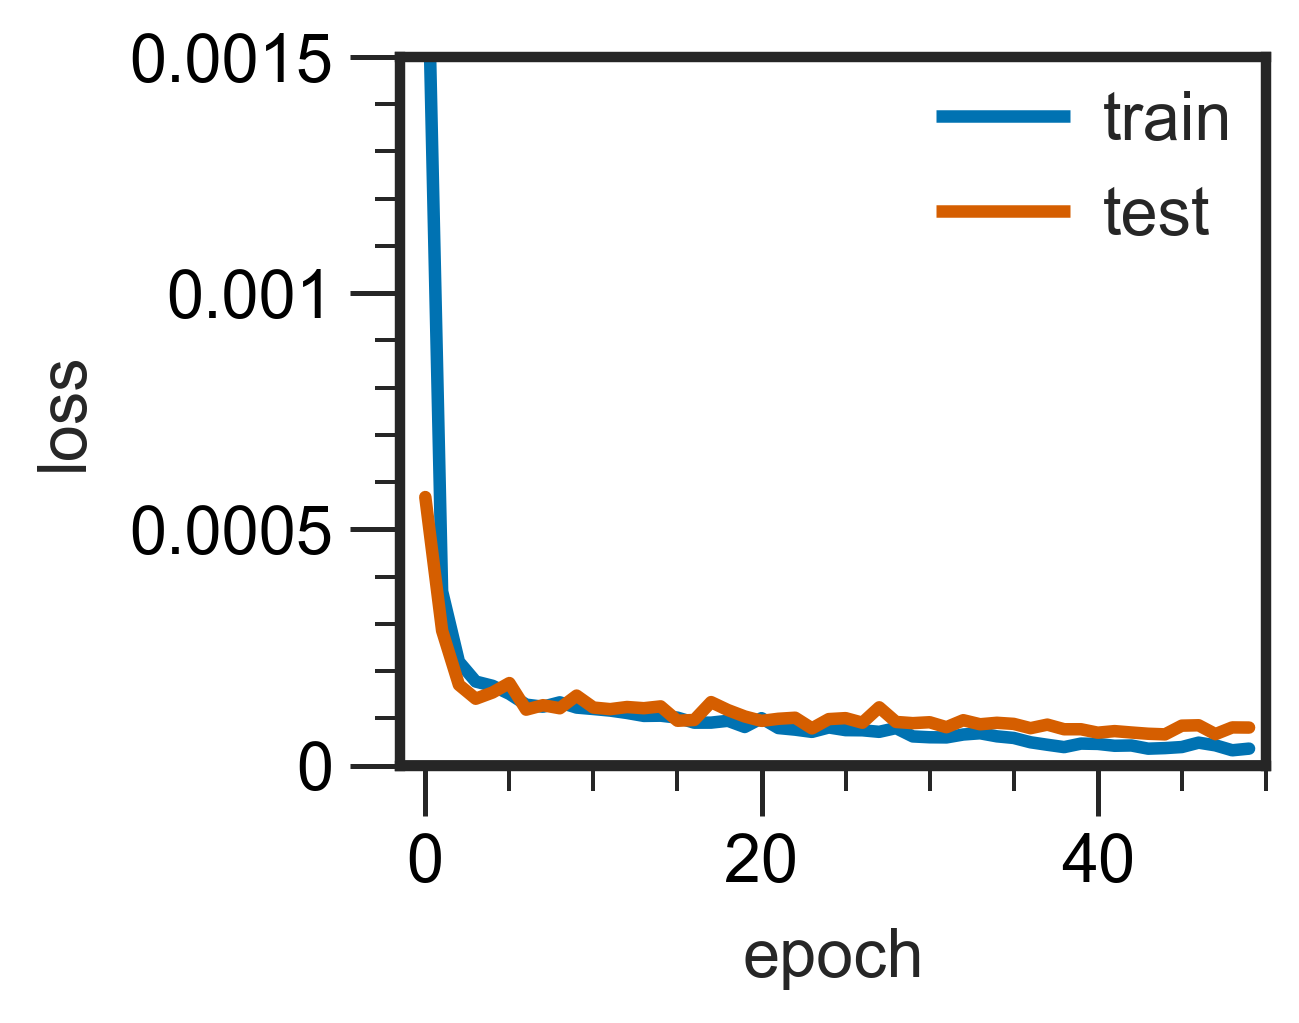

In [7]:
pplt.rc['cmap.discrete'] = False
pplt.rc['pdf.fonttype'] = 42
pplt.rc['font.size'] = 8
pplt.rc['font.sans-serif'] = ['TeX Gyre Heros', 'sans-serif']
pplt.rc['mathtext.default'] = 'it'
pplt.rc['mathtext.fontset'] = 'custom'
pplt.rc['grid'] = False
mpl.style.use('seaborn-ticks')
dpi = 300

# print loss of re-training
fig = pplt.figure(width='55mm', refheight='30mm', sharex=True, sharey=True, dpi=300)
axs = fig.subplots(nrows=1, ncols=1,ylim=[0,0.0015], xlim=[-1.5,n_epochs])
axs.format(xlabel='epoch', ylabel='loss')

s = 10
leg_pad = -.5

loss_array = np.array(history.history['loss'])
val_loss_array = np.array(history.history['val_loss'])

ax = axs[0]
ax.plot(loss_array/5, label = 'train')
ax.plot(val_loss_array/5,  label = 'test')
ax.legend(ncols=1, handletextpad=0.5, loc='upper right')
ax.axhline(0, zorder=-10, c='k')
plt.show()

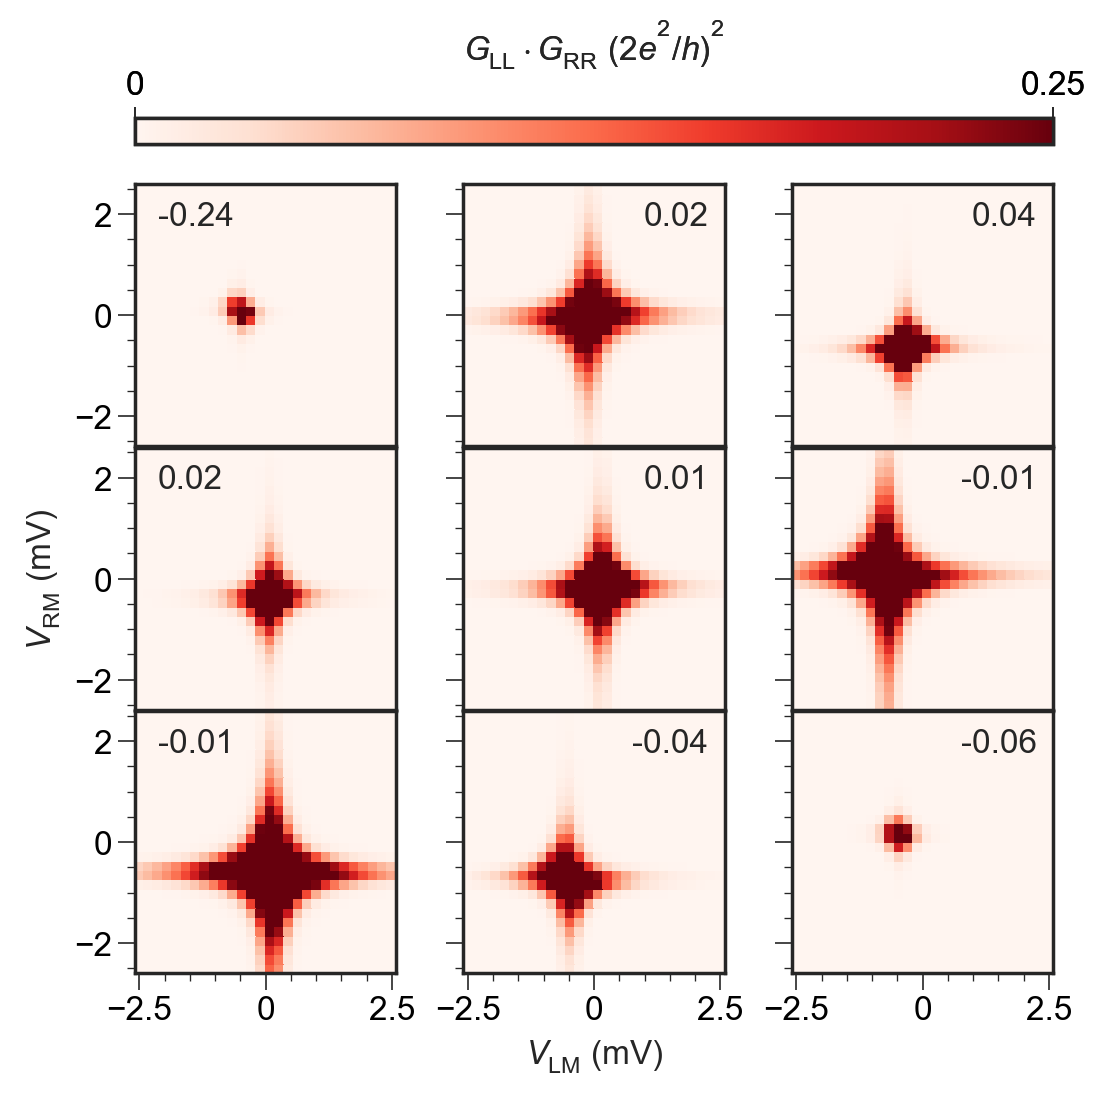

In [8]:
pplt.rc['cmap.discrete'] = False
pplt.rc['pdf.fonttype'] = 42
pplt.rc['font.size'] = 12
pplt.rc['font.sans-serif'] = ['TeX Gyre Heros', 'sans-serif']
pplt.rc['mathtext.default'] = 'it'
pplt.rc['mathtext.fontset'] = 'custom'
pplt.rc['grid'] = False
mpl.style.use('seaborn-ticks')
dpi = 300

# fig = pplt.figure(height='140mm',sharex=True, sharey=False, hspace=0)
fig = pplt.figure(width='140mm',sharex=True, sharey=True, wspace=2.0, hspace=0.05)
axs = fig.subplots(nrows=3,ncols=3)
local_max = 0.25
nonlocal_max = 0.1
leg_pad=-1.8

X, Y = np.linspace(-2.5, 2.5, 28), np.linspace(-2.5, 2.5, 28)
G_corr = G_LL_RR_28[:,:,:,0]


# 1st column
p1 = axs[0,0].pcolor(X, Y, G_corr[0,:,:], vmin=0, vmax=local_max, cmap='Reds', 
                label=np.round(label_ratio[0],decimals=2)[0])
axs[0,0].legend(ncols=1, handletextpad=leg_pad, loc='upper left')

axs[1,0].pcolor(X, Y, G_corr[3,:,:], vmin=0, vmax=local_max, cmap='Reds',
               label=np.round(label_ratio[3],decimals=2)[0])
axs[1,0].legend(ncols=1, handletextpad=leg_pad, loc='upper left')

axs[2,0].pcolor(X, Y, G_corr[10,:,:], vmin=0, vmax=local_max, cmap='Reds',
               label=np.round(label_ratio[10],decimals=2)[0])
axs[2,0].legend(ncols=1, handletextpad=leg_pad, loc='upper left')

# 2nd column
axs[0,1].pcolor(X, Y, G_corr[47,:,:], vmin=0, vmax=local_max, cmap='Reds',
               label=np.round(label_ratio[47],decimals=2)[0])
axs[0,1].legend(ncols=1, handletextpad=leg_pad, loc='upper right')

axs[1,1].pcolor(X, Y, G_corr[8,:,:], vmin=0, vmax=local_max, cmap='Reds',
               label=np.round(label_ratio[8],decimals=2)[0])
axs[1,1].legend(ncols=1, handletextpad=leg_pad, loc='upper right')

axs[2,1].pcolor(X, Y, G_corr[16,:,:], vmin=0, vmax=local_max, cmap='Reds',
               label=np.round(label_ratio[16],decimals=2)[0])
axs[2,1].legend(ncols=1, handletextpad=leg_pad, loc='upper right')

# 3rd column
axs[0,2].pcolor(X, Y, G_corr[1,:,:], vmin=0, vmax=local_max, cmap='Reds',
               label=np.round(label_ratio[1],decimals=2)[0])
axs[0,2].legend(ncols=1, handletextpad=leg_pad, loc='upper right')

axs[1,2].pcolor(X, Y, G_corr[6,:,:], vmin=0, vmax=local_max, cmap='Reds',
               label=np.round(label_ratio[6],decimals=2)[0])
axs[1,2].legend(ncols=1, handletextpad=leg_pad, loc='upper right')

axs[2,2].pcolor(X, Y, G_corr[12,:,:], vmin=0, vmax=local_max, cmap='Reds',
               label=np.round(label_ratio[12],decimals=2)[0])
axs[2,2].legend(ncols=1, handletextpad=leg_pad, loc='upper right')



axs[0,1].format(xlabel=r'$V_\mathrm{LM}$ (mV)')   
axs[1,0].format(ylabel=r'$V_\mathrm{RM}$ (mV)', labelpad = 10)

cbar = fig.colorbar(p1, loc='t', width=0.13, label=r'$G_\mathrm{LL} \cdot G_\mathrm{RR} \ (2e^2/h)^2$')
cbar.set_ticks([0,.25])

# fig.save(fig_dir+"Y.png", dpi=300)
plt.legend()
plt.show()

list_ratios = [label_ratio[0], label_ratio[3], label_ratio[10], 
               label_ratio[47], label_ratio[8], label_ratio[16],
               label_ratio[1], label_ratio[6], label_ratio[12]]

# re-training on measurements

In [9]:
# original data
GLL_exp = np.load('data/GLL_exp.npy')
GRR_exp = np.load('data/GRR_exp.npy')
G_labels_exp = np.load('data/G_labels_exp.npy')

# correlated extended data: GLL*GRR for slightly different center positions (5x75 original measurements)
G_corr_exp_train = np.load('data/G_corr_exp.npy')
G_labels_exp_train = np.load('data/G_labels_exp_train.npy')

In [10]:
G_corr_exp_train.shape

(375, 28, 28, 1)

In [11]:
# re-training
history_retraining = model.fit([G_corr_exp_train[0:375,:,:,:], G_corr_exp_train[0:375,:,:,:]], 
                    np.array(G_labels_exp_train)[0:375], epochs=25, batch_size=8, validation_split=0.2)

Epoch 1/25
38/38 [==============================] - 1s 15ms/step - loss: 0.0902 - val_loss: 0.0022
Epoch 2/25
38/38 [==============================] - 0s 11ms/step - loss: 7.7825e-04 - val_loss: 1.5198e-04
Epoch 3/25
38/38 [==============================] - 0s 10ms/step - loss: 1.1793e-04 - val_loss: 1.0694e-04
Epoch 4/25
38/38 [==============================] - 0s 10ms/step - loss: 7.8399e-05 - val_loss: 5.9829e-05
Epoch 5/25
38/38 [==============================] - 0s 11ms/step - loss: 6.1560e-05 - val_loss: 5.0341e-05
Epoch 6/25
38/38 [==============================] - 1s 14ms/step - loss: 5.0386e-05 - val_loss: 4.4366e-05
Epoch 7/25
38/38 [==============================] - 0s 11ms/step - loss: 4.5916e-05 - val_loss: 4.0322e-05
Epoch 8/25
38/38 [==============================] - 0s 12ms/step - loss: 3.9220e-05 - val_loss: 3.7023e-05
Epoch 9/25
38/38 [==============================] - 0s 13ms/step - loss: 3.5360e-05 - val_loss: 3.3939e-05
Epoch 10/25
38/38 [==========================

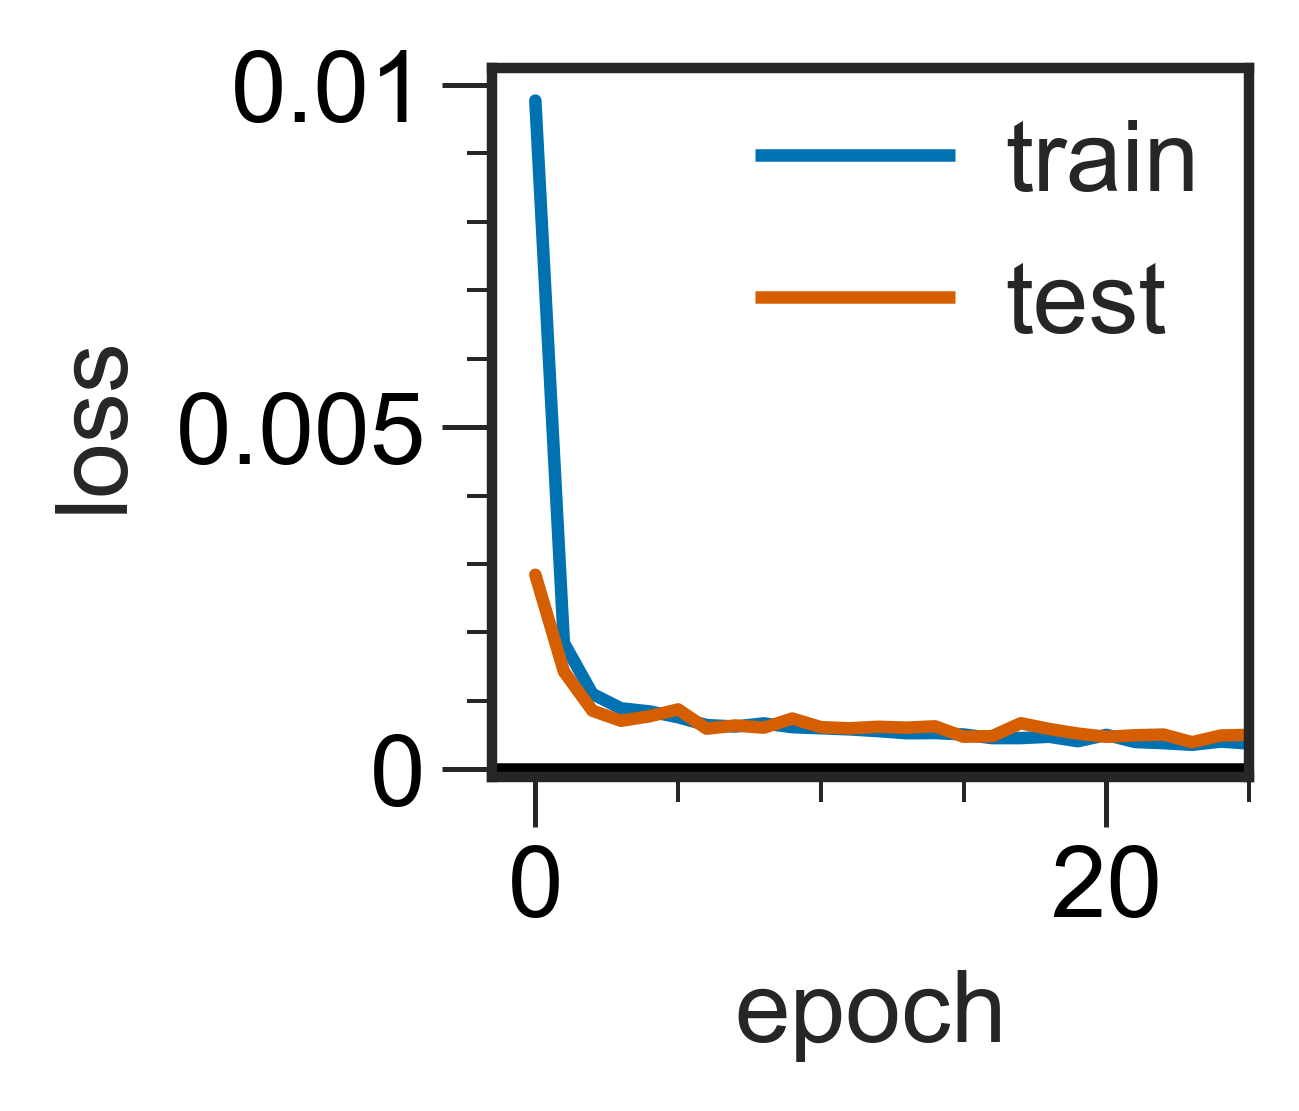

In [13]:
# print loss of re-training
fig = pplt.figure(width='55mm', refheight='30mm', sharex=True, sharey=True, dpi=300)
axs = fig.subplots(nrows=1, ncols=1, xlim=[-1.5,25])
axs.format(xlabel='epoch', ylabel='loss')
s = 10
leg_pad = -.5

ax = axs[0]
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'],  label = 'test')
ax.legend(ncols=1, handletextpad=0.5, loc='upper right')
ax.axhline(0, zorder=-10, c='k')
plt.show()
